# TAD Week 6: Dimensionality Reduction

To include in the mini-lecture
* geometric description of multi-d data
* intuitive explanation of PCA
* mathematical equation for PCA reconstruction


Today is a bit of a change from the previous weeks. Instead of focusing on statistical tests or models, we will focus instead on another important technique in data analysis: dimensionality reduction. 

As you saw in today's mini-lecture, principal component analysis (PCA) is a powerful tool for visualizing your data in a low-dimensional space for two reasons: it is guaranteed to capture the axes of maximum variance in your data (i.e., it is optimal and objective), and it is a linear transform (i.e. it is easy to compute and understand). UMAP is also a powerful tool, but for very different reasons: it attempts to find some low-dimensional sub-space along which your data are scattered, and to reduce that sub-space to a few dimensions while preserving the relationship of the original data. UMAP is neither optimal nor objective, opting instead for flexibility -- as we will see, this has its pros and cons.

To illustrate these basic properties of PCA and UMAP, we start with MNIST, a classic machine learning dataset. Then we do a deep dive into UMAP with some scRNA-seq data, looking at its dependence on key parameters, some of its failure modes, and whether or not it really does what it claims to do!

In [1]:
# If on Colab, run:
# !pip install umap
# !pip install umap-learn[plot]

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
import umap
import umap.plot
from sklearn.datasets import fetch_openml
from itertools import repeat
from scipy.spatial.distance import euclidean

from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale
from sklearn.decomposition import TruncatedSVD
from scipy import stats
import scipy.io as sio
import os

In [3]:
# Imports for interactive UMAP plotting
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper
from bokeh.palettes import Spectral10


In [4]:
# Some helper functions

def plot_MNIST_sample(X):
    """
    Plots 9 images in the MNIST dataset.
    Credit: https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/student/W1D4_Tutorial3.html
    
    Args:
     X (numpy array of floats) : Data matrix each column corresponds to a
                                 different random variable
    Returns:
    Nothing.
    """

    fig, ax = plt.subplots()
    k = 0
    for k1 in range(3):
        for k2 in range(3):
            k = k + 1
            plt.imshow(np.reshape(X[k, :], (28, 28)),
                     extent=[(k1 + 1) * 28, k1 * 28, (k2+1) * 28, k2 * 28],
                     vmin=0, vmax=255, cmap='viridis')
            plt.xlim((3 * 28, 0))
            plt.ylim((3 * 28, 0))
            plt.tick_params(axis='both', which='both', bottom=False, top=False,
                      labelbottom=False)
            plt.clim([0, 250])
            ax.set_xticks([])
            ax.set_yticks([])
    plt.show()
    
    
def plot_MNIST_weights(weights):
    """
    Visualize PCA basis vector weights for MNIST. Red = positive weights,
    blue = negative weights, white = zero weight.
    Credit: https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/student/W1D4_Tutorial3.html

    Args:
    weights (numpy array of floats) : PCA basis vector

    Returns:
    Nothing.
    """
    fig, ax = plt.subplots()
    cmap = plt.cm.get_cmap('seismic')
    plt.imshow(np.real(np.reshape(weights, (28, 28))), cmap=cmap)
    plt.tick_params(axis='both', which='both', bottom=False, top=False,
                  labelbottom=False)
    plt.clim(-.15, .15)
    plt.colorbar(ticks=[-.15, -.1, -.05, 0, .05, .1, .15])
    ax.set_xticks([])
    ax.set_yticks([])
    
    
def get_variance_explained(X):
    """
    Use the covariance matrix to calculate variance explained
    along each axis (variable) for the data in X (n obs x n vars).
    
    NB, uses np.cov(rowvar=False)! 
    
    Args:
        X (np array): n obs x n vars matrix
        
    Returns:
        Variance explained by each variable of X (diags of cov)
    """
    cov = np.cov(X, rowvar=False)
    return cov[np.eye(X.shape[1]) == 1]


# Utility for the bokeh function
def embeddable_image(data):
    """See: https://www.kaggle.com/code/parulpandey/part3-visualising-kannada-mnist-with-umap/notebook
    """
    img_data = 255 - 15 * data.astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((28,28), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()


def hoverable_2d_scatter_with_images(data, labels, unwrapped_images, image_dims, s=4):
    """
    Takes x/y data and makes a scatter plot that is 1) colored by label,
    2) hoverable with Bokeh, and 3) optionally has images associated with each point
    
    Lightly modified from: https://www.kaggle.com/code/parulpandey/part3-visualising-kannada-mnist-with-umap/notebook
    
    data (np.array): n obs x 2 (x,y)
    labels (np.array): n obs
    unwrapped_images (np.array): n obs x n pixels
    image_dims (tuple or list): width x height to re-wrap images
    """
    
    assert data.ndim == 2
    assert data.shape[1] == 2
    
    assert data.shape[0] == labels.shape[0] == unwrapped_images.shape[0]
    
    assert len(image_dims) == 2
    assert np.product(image_dims) == unwrapped_images.shape[1]

    rewrapped_images = unwrapped_images.reshape(unwrapped_images.shape[0], image_dims[0], image_dims[1])

    digits_df = pd.DataFrame(data, columns=('x', 'y'))
    digits_df['digit'] = [str(lab) for lab in labels]
    digits_df['image'] = list(map(embeddable_image, rewrapped_images))


    datasource = ColumnDataSource(digits_df)
    color_mapping = CategoricalColorMapper(factors=[str(9 - x) for x in labels],
                                           palette=Spectral10)

    plot_figure = figure(
        title='UMAP projection of the MNIST dataset',
        plot_width=600,
        plot_height=600,
        tools=('pan, wheel_zoom, reset')
    )

    plot_figure.add_tools(HoverTool(tooltips="""
    <div>
        <div>
            <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
        </div>
        <div>
            <span style='font-size: 16px; color: #224499'>Digit:</span>
            <span style='font-size: 18px'>@digit</span>
        </div>
    </div>
    """))

    plot_figure.circle(
        'x',
        'y',
        source=datasource,
        color=dict(field='digit', transform=color_mapping),
        line_alpha=0.6,
        fill_alpha=0.6,
        size=s
    )
    show(plot_figure)

    

In [5]:
def equally_spaced_pts_on_a_sphere(n=100, return_angles=False):
    """
    Taken from: http://extremelearning.com.au/how-to-evenly-distribute-points-on-a-sphere-more-effectively-than-the-canonical-fibonacci-lattice/
    """

    if n >= 600000:
        epsilon = 214
    elif n>= 400000:
        epsilon = 75
    elif n>= 11000:
        epsilon = 27
    elif n>= 890:
        epsilon = 10
    elif n>= 177:
        epsilon = 3.33
    elif n>= 24:
        epsilon = 1.33
    else:
        epsilon = 0.33

    goldenRatio = (1 + 5**0.5)/2
    i = np.arange(0, n) 
    theta = 2 * np.pi * i / goldenRatio
    phi = np.arccos(1 - 2*(i+epsilon)/(n-1+2*epsilon))
    x, y, z = np.cos(theta) * np.sin(phi), np.sin(theta) * np.sin(phi), np.cos(phi);
    
    if return_angles:
        return x,y,z,theta,phi
    else:
        return x,y,z

def equally_spaced_pts_on_a_square_lattice(ndim=3, grid_min=0, grid_max=5, grid_spacing=1):
    """ 
    Use np.meshgrid to generate an evenly-spaced lattice.
    Recall total data size will be (gridsize ** ndim) * ndim!
    
    Returns: pd.DataFrame of n pts x n dims
    """
    x = np.arange(grid_min, grid_max, grid_spacing)
    Xs = np.meshgrid(*repeat(x, ndim))  # meshgrid infers ndims from num of args, so repeat the arg ndims times. Equivalent to np.meshgrid(x,x,x,x,...)
#     df = pd.DataFrame({f'X{i}': Xs[i].flatten() for i in range(len(Xs))})
    data = [Xs[i].flatten() for i in range(len(Xs))]
    return data


def scatter_3d_from_matrix(mat, **kwargs):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(mat[:,0], mat[:,1], mat[:,2], **kwargs)
    return ax


def uniformity_via_norm(v, p=2):
    """ Returns uniformity (scaled from 0 to 1) of a vector via it's L-p norm
    """
    v = v / np.sum(np.abs(v))  # make into a probability distribution
    min_val = 1/np.sqrt(len(v))
    rng = 1 - min_val
    norm = np.linalg.norm(v, ord=p) 
    return 1 - ((norm - min_val) / rng)


## Loading the data

We will start with the MNIST dataset for the first few exercises. This is a set of 70,000 low-res images of handwritten digits. Each image is 28x28, and each image is unwrapped in the data, so we'll be working with a 70,000 x 28^2 (784) matrix. MNIST is a classic machine learning dataset -- many ML researchers spend years trying to shave off tenths of percentage points of accuracy on it! See eg: https://benchmarks.ai/mnist. It is generally considered to be an easy problem in machine learning; very simple classifiers perform >90% accurate.

Here, we won't bother with classification, but the semantic meaning of the data points as numbers will help us to understand what PCA is doing with the data.

In [6]:
# Get mnist data (takes ~30 seconds)
mnist = fetch_openml(name='mnist_784', as_frame = False)

In [7]:
X = mnist.data.astype('int')
y = mnist.target.astype('int')  # 70,000-integer vector; tells which digit is represented by each image

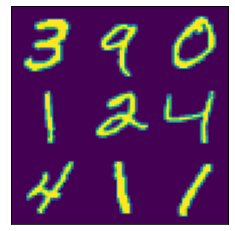

In [8]:
# Visualize nine of the images
plot_MNIST_sample(X)

## PCA Visualization
This PCA tutorial is partially borrowed / entirely inspired by NeuroMatch Academy's Dimensionality Reduction tutorial: https://compneuro.neuromatch.io/tutorials/W1D4_DimensionalityReduction/student/W1D4_Tutorial3.html

Let's run PCA on the MNIST dataset and see what we get. Scikit-learn has a [handy PCA object](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) that takes care of the math for us. Run the following cells and then answer questions 1-5.

In [9]:
from sklearn.decomposition import PCA

# Initialize a pca model
pca = PCA(random_state=2022)

# Normalize each variable (ie columnn) (ie pixel position) by subtracting its mean across the dataset
X_norm = X - X.mean(axis=0)  

# Run PCA on the data ("fit"), and return the representation of the data in the new coordinates ("transform")
pca.fit(X_norm)
X_transform = pca.transform(X_norm)  # n images x n pcs

# Extract PCs and var explained from the model object
components = pca.components_
explained_variance = pca.explained_variance_

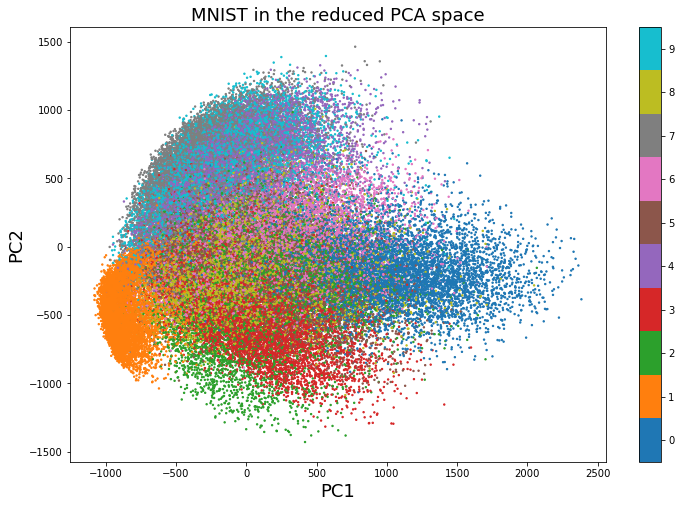

In [10]:
# Plot the data in the new coordinates
x_pc = 0
y_pc = 1

plt.figure(figsize=(12,8))
plt.scatter(X_transform[:,x_pc], X_transform[:,y_pc], s=2, c=y, cmap='tab10')
plt.xlabel('PC1', fontsize=18)
plt.ylabel('PC2', fontsize=18)
plt.title('MNIST in the reduced PCA space', fontsize=18)
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)

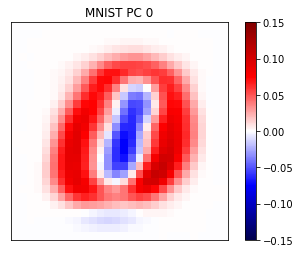

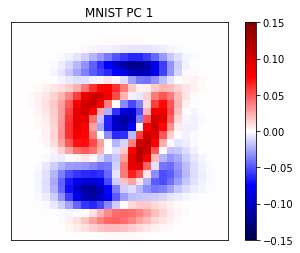

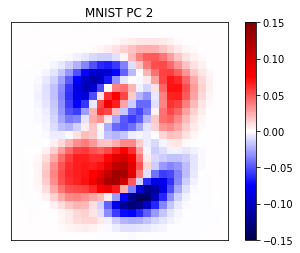

In [11]:
# Visualize the components (each 1 x num pixels) as if they were also digits

for i in range(3):
    plot_MNIST_weights(components[i,:])
    plt.title(f'MNIST PC {i}')

Text(0.5, 1.0, 'Scree plot for MNIST PCA (variance explained by i-th component)')

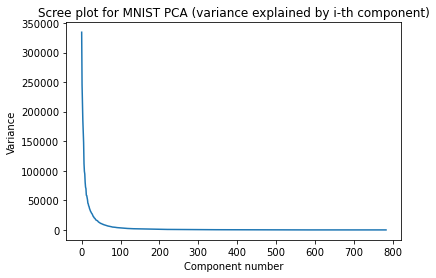

In [12]:
# Plot the explained variance vs the i-th PC
plt.plot(explained_variance)
plt.xlabel('Component number')
plt.ylabel('Variance')
plt.title('Scree plot for MNIST PCA (variance explained by i-th component)')

In [13]:
#TODO (Q2): what percentage of the total variance does the first principal component explain?
percent_explained_PC1 = 100 * explained_variance[0] / explained_variance.sum()

print(percent_explained_PC1)

9.746115922494736


### Answer the following questions based on information from the lecture and your results above

**QUESTION 1:** Which of the following questions does PCA analysis help to answer?
* Which set of new vectors best reconstrcut the original data?
* Which new basis vectors best linearly decorrelate the data?
* Which new basis vectors describe the axes along which the data vary most?
* Which new basis vectors are mutually orthogonal?

**QUESTION 2:** What percentage of the total variance (rounded to one decimal) does PC1 explain in the MNIST data?

**QUESTION 3:** in the scatter plot of MNIST PC1 vs. PC2, what does each point represent?
* One picture from the dataset
* One pixel from one picture from the dataset
* One component of the PCA results

**QUESTION 4:** How would you interpret MNIST PC1's meaning? What does it tell you about the digits in the dataset? (Hint: recall the key attribute of the first principal component.)

Answer: it appears that PC1 (or "PC0" in the plot) captures the difference between round digits like 0's and 8's, and more linear digits like 1/4/7/9. It also shows that all the digits are nicely centered (because there isn't much variance captured in the corners).

**QUESTION 5:** About how many principal components would you use to reconstruct the MNIST dataset with high accuracy but substantially reduced dimensionality? 
* 2
* 20
* 100


1554.3962067060588


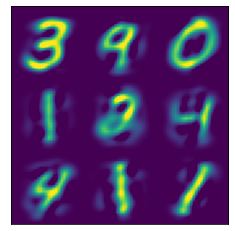

In [15]:
# TODO: using the number of PCs from question 5, reconstruct the orginal MNIST dataset 
# from the transformed data and the principal components. Then determine the mean squared error for your reconstruction.

# Hint: you'll need to use matrix multiplication, and don't forget to add back the column means!

n_pcs_to_use = 20
X_reconstructed = X_transform[:, :n_pcs_to_use] @ components[:n_pcs_to_use, :] + X.mean(axis=0)  
reconstruction_pca_mse = np.mean((X - X_reconstructed)**2)
print(reconstruction_pca_mse)

plot_MNIST_sample(X_reconstructed)


**QUESTION 6:** What is the mean squared error for your reconstruction?
    
    

You should see readable, if slightly blurry, digits in the plot above!

## Comparing PCA to random projections
Another common technique for performing dimensionality reduction (although it is becoming less common as computers get faster) is using random projections. Instead of calculating the optimal set of projection axes (i.e. the principal components), we just use random ones that happen to have decent statistical properties, on average.

Here, we compare one type of random projections to PCA, based on variance explained by the axes of the projections.

In [15]:
from sklearn.random_projection import SparseRandomProjection

n_iter = 100
np.random.seed(2022)

# TODO: simulate many different random projections of the MNIST dataset. 
# Get the maximum variance explained by any single dimension of the transformed data, 
# and compare the distribution of these values to the maximum variance explained from PCA (ie PC1).

# Hint: use the helper function get_variance_explained() defined above.

max_var_explained = np.zeros(n_iter,)
for i in range(n_iter):
    sparse_rand_proj = SparseRandomProjection(n_components=200).fit(X_norm)
    X_rand = sparse_rand_proj.transform(X_norm)
    max_var_explained[i] = np.max(get_variance_explained(X_rand))
    

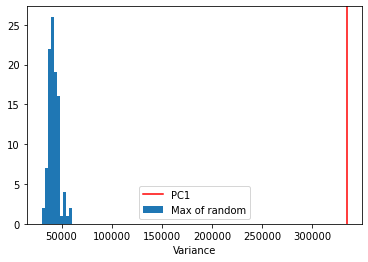

In [16]:
plt.hist(max_var_explained, label='Max of random')
plt.axvline(explained_variance[0], color='r', label='PC1')
plt.xlabel('Variance')
plt.legend()

**QUESTION 7:** On average, how many times more/less variance does the best sparse projection component explain than the first principal component?

In [17]:
# TODO: answer question 7
variance_ratio = explained_variance[0] / np.mean(max_var_explained) 
variance_ratio

7.860024824395427

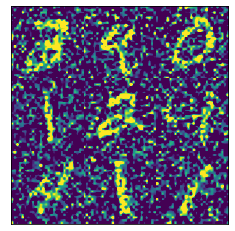

In [18]:
# TODO: similar to how you did above, reconstruct the original MNIST data from a sparse random projection.
# Then calculate the MSE, and visualize it.

n_sparse_dims_to_use = int(variance_ratio * n_pcs_to_use) # Multiply these so that the reconstructions explain roughly similar amounts of variance.
sparse_rand_proj = SparseRandomProjection(n_components=n_sparse_dims_to_use).fit(X_norm)
X_rand = sparse_rand_proj.transform(X_norm)
X_reconstructed_from_sparse = X_rand @ sparse_rand_proj.components_ + X.mean(axis=0)


plot_MNIST_sample(X_reconstructed_from_sparse)

**QUESTION 8:** How does the sparse random reconstruction differ from the PCA-based reconstruction? Explain why it differs in this way.

Answer: the sparse random reconstruction is much noisier, with speckled (or "salt and pepper") random noise. The components of the sparse random reconstruction will have large loadings on random dimensions (i.e. pixels), whereas the components of the PCA will have large loadings on the dimensions (pixels) where the most variance is contained (i.e. what we saw in PC1). Because of this, the sparse random reconstruction has some noise in random dimensions (pixels) where the PCA reconstruction does not.

Before we leave PCA, it is worth acknowledging that there are lots of other linear dimensionality reduction algorithms out there. If you're interested in applying dimensionality reduction to neural activity, I highly recommend [this video](https://youtu.be/zeBFyRaoVnQ?t=1394) by Byron Yu; this link points you to the part of the video where he covers a bunch of different techniques and when you might use each one. Very useful!

## UMAP for clustering

Now, let's run UMAP on the MNIST dataset and see how the results differ from PCA. Run the cells, then answer the questions below. (No code to write in this section.)

In [19]:
# This cell may take 1-2 minutes

# Initialize the UMAP model for 2d 
umap_model = umap.UMAP(n_components=2, random_state=2022)

# Run UMAP on the data ("fit"), and return the representation of the data in the new coordinates ("transform")
# Note: use the raw MNIST data, not the normalized data.
embedding = umap_model.fit_transform(X)

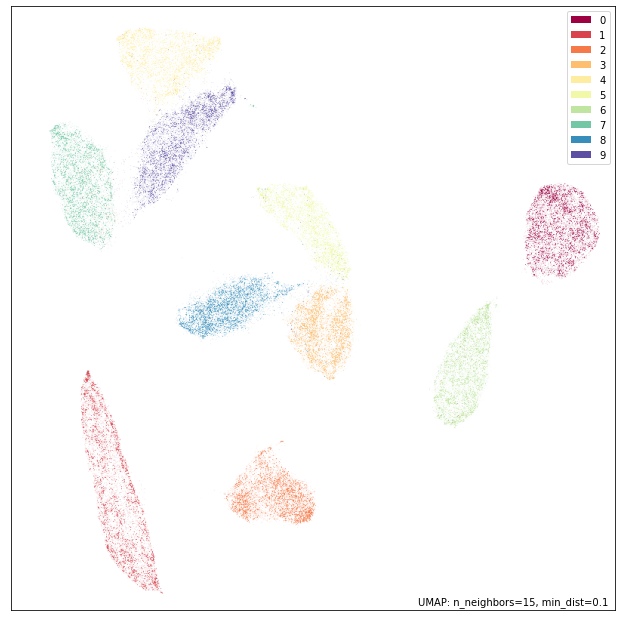

In [20]:
# Plot the data with UMAP's built-in plotting utility; this uses datashader on the backend to make a nice tidy plot
umap.plot.points(umap_model, labels=y)
hover_data = pd.DataFrame({'index':np.arange(X.shape[0]),
                           'label':y})

In [ ]:
# We can also plot the data with an interactive package called holoviews (Bokeh)
# NOTE: if this cell fails, you can use an online widget with the same functionality here:
# https://grantcuster.github.io/umap-explorer/

# Start Bokeh
output_notebook()

# Make the plot
hoverable_2d_scatter_with_images(embedding, y, X, (28,28), s=2)

### Answer these questions based on the PCA and UMAP analyses above of the MNIST data.

**QUESTION 9:**: UMAP appears to separate the digits far better than PCA did. This suggests that the data are separable in what way?
* Linearly
* Non-linearly
* Uniformly

**QUESTION 10:** UMAP attempts to preserve local structure in the data. Using the hover tooltip, examine the way that the digits change within each digit cluster (i.e. from the top to bottom of all the 1's). Did UMAP appear to preserve local structure in this case?

Answer: yes!

**QUESTION 11:** Zoom into the left edge of the 6's cluster. You should see a few points that are not 6's (colored differently). Examine the corresponding images. What happened here -- did UMAP make a mistake? (NB: if the interactive plot doesn't work, try this website: https://grantcuster.github.io/umap-explorer/)

Answer: no -- these non-6 digits look a lot like 6's! If you trained a k-neareast-neighbors classifier on the UMAP output, then sure, it would probably make a mistake and call those digits 6's. But it's hard to justify saying that UMAP made a "mistake". I would say that it accurately captured the similarity of some non-6 digits to the rest of the 6's.

**QUESTION 12:** Compare and contrast the insights into the MNIST dataset that PCA and UMAP give us. Which do you feel reveals more about the dataset?

Answer: no right answer here. I personally prefer the PCA analysis because it tells me something concrete about the way the data vary across the dataset that isn't necessarily intuitive. I think it is much more intuitive that some 7's look like 9's, etc. 

***

## "The Specious Art of Single-Cell Genomics"

This exercise recreates a piece of data from Chari et al. 2021, a paper from Lior Pachter's lab that examines the use of clustering algorithms like PCA and UMAP in the analysis of single-cell RNA sequencing data. The paper's main argument is that investigators should not do quantifications in UMAP output space (i.e. cell-to-cell distance, relative spacing of different cell types, "trajectories") in order to draw conclusions about biological variables of interest, because UMAP distorts the data too heavily to be interpretable. 

Their line of reasoning is two-fold. First, it is impossible to reduce high-dimensional data to low-dimensional data without distorition; this is a mathematical fact, and is unavoidble. So, second, the authors ask, how good of a job does UMAP do at doing that reduction, given the inevitable distortions? The authors argue that it does a very bad job, and to prove their point, they design an auto-encoder that, by their metrics, performs just as well as UMAP in maitaining the characteristics of the original data, but shapes the 2D data in any way you like (for example, an elephant or a world map). 

**Here, we recreate one piece of data from their Figure 2b: the correlation between all inter-cell-type distances as measured in ambient space (i.e. the raw RNAseq data, log-normalized gene counts); PCA space; and PCA-UMAP space.**

To operationalize that for this exercise: we give you a gene expression dataset with $T$ annotated cell types and $G$ genes. First we find the centroid (mean) of each cell type in the dataset. Then we find the set of $T*(T-1)/2$ inter-centroid distances. We repeat that calculate for the ambient (raw data), PCA (ndim=50 here), and PCA-UMAP (ndim=2) spaces. Finally, we correlate the $T*(T-1)/2$-length vectors in pairs (ambient vs. PCA and ambient vs. PCA-UMAP), in order to see how well the PCA and UMAP reductions preserve inter-cell-type distances of the ambient space.

A technical note: in single-cell analysis, it is standard practice to perform UMAP *on top of* PCA. That is, one first runs PCA on the data; then one runs UMAP on the output of the PCA. This is because UMAP tends to fail in very high dimensions (i.e. many thousands, which is what single cell analyses often have), but PCA can help reduce that number to ~50 or so. So we are comparing "PCA" and "PCA-UMAP" spaces, but we will often just call the latter "UMAP".

In [22]:
# # Load the data on Colab:
# !gdown --id 15DhuMW3kFymhsI5C1XHRs-ZJ19wrZYwl
# data_path = '/content/metadata.csv'
# meta = pd.read_csv(os.path.join(data_path), index_col=0)

# !gdown --id 1I1vTPRcWINb8n2cl3ZCTkonUpchXTHhU
# data_path = '/content/tenx.mtx'
# count_mat = sio.mmread(data_path)


In [23]:
# Load the data locally
data_path = '/Users/jonahpearl/Documents/PiN/G3/TAD/TAD_python/data'
count_mat = sio.mmread(os.path.join(data_path, 'tenx.mtx'))
meta = pd.read_csv(os.path.join(data_path, 'metadata.csv'), index_col=0)
count_mat.shape

(41580, 1999)

In [24]:
print(meta.shape)
meta.head()

(41580, 13)


,sample_name,cell_barcode,cluster_color,cluster,cluster_id,cell_types,sex_label,batch_indices,cell_counts,n_genes,percent_mito,pass_count_filter,pass_mito_filter
0,10x_VMH_Female_Control_1,4_AAACCTGAGCGCCTCA,#9162FF,Nr5a1_4,24.0,undefined,F,0,1427.0,926,13.594954,True,False
1,10x_VMH_Female_Control_1,4_AAACCTGCACAGTCGC,#96FF2E,Tsix_Esr1_1,3.0,undefined,F,0,4508.0,2310,9.272405,True,False
2,10x_VMH_Female_Control_1,4_AAACCTGCAGATTGCT,#66ABC2,Dlk1_3,16.0,undefined,F,0,3447.0,1995,5.483029,True,False
3,10x_VMH_Female_Control_1,4_AAACCTGCATACTCTT,#96FF2E,Tsix_Esr1_1,3.0,undefined,F,0,7004.0,3286,4.483152,True,True
4,10x_VMH_Female_Control_1,4_AAACCTGGTCCGTTAA,#24EFCD,Scgn,20.0,undefined,F,0,2490.0,1492,9.277108,True,False


Let's briefly examine the data.

**QUESTION 13**: How many genes are present in this dataset? How many cells? (Hint: think about what count_mat and meta each represent.) 

Answer: 1999 genes, 41580 cells

**QUESTION 14**: Which of these is represents the dimensionality of the data?

Answer: the genes. Each cell is an observation; each gene is a predictor / variable in the dataset.

**QUESTION 15**: How many unique cell types ("clusters") are there in this data set?

Answer: 30

In [25]:
#TODO: find the number of unique cell types in the data set (hint -- this can be done in one simple line of code!)
meta.cluster.unique().shape

(30,)

Let's find the centroids for each cell type.

In [26]:
#TODO: write a function to find the centroids for each cluster

def get_centroids(counts, cluster_labels):
    """Get centroids of clusters in a set of points
    Arguments:
        counts {np.array} -- a cells x genes matrix of rna counts
        cluster_labels {array or list} -- cluster labels for each cell
    
    Returns:
        clusters {np.array} -- list of all unique clusters
        centroids {np.array} -- the centroid for each corresponding cluster
    """
    unique_clusters = np.unique(cluster_labels)
    centroids = np.zeros((len(unique_clusters), counts.shape[1]))
    
    for i in range(len(unique_clusters)):
        rows_in_cluster = (cluster_labels == unique_clusters[i])  # boolean vector for this cell type 
        centroids[i, :] = np.mean(counts[rows_in_cluster, :], axis=0)  # extract gene counts and take the mean across cells
    
    return unique_clusters, centroids

# Use your function to get the centroids for each cluster in the ambient space (count_mat)
clusters, centroids = get_centroids(count_mat, meta.cluster)

**QUESTION 16:** What is the value of the second dimension of the centroid of the Esr1_6 cells?

In [27]:
# TODO: find the value of the second dimension of the centroid of the Esr1_6 cells
esr1_6_idx = np.where(clusters == 'Esr1_6')[0]
centroids[esr1_6_idx][0,1]

0.12833322099229655

In [28]:
#TODO: write a function that gets the T(T-1)/2 inter-centroid distances, and returns them as a single vector.
def get_pairwise_dists(points):
    """Get pairwise L1 distances of a set of points
    Arguments:
        points {np.array} -- a points x dimensions matrix
    Returns:
        dists {np.array} -- a vector of size N*N-1 pairwise distances
    """
    
    all_dists = pairwise_distances(points, points, metric='l1')  # hint: check out scipy.metric.pairwise_distances. Make sure to use the L1 norm!
    
    # Remove redundant pairs
    dists = np.triu(all_dists)
    dists = dists[dists != 0]
    
    return dists
    

**QUESTION 17**: What is the mean pairwise distance between clusters in the ambient space?

In [29]:
pairwise_dist_vector = get_pairwise_dists(centroids)
pairwise_dist_vector.mean()

418.10861115318295

In [30]:
assert pairwise_dist_vector.shape[0] == centroids.shape[0]*(centroids.shape[0] - 1)/2

In [31]:
# Helper function to transform the data with PCA and UMAP. 
def get_pca_and_umap(counts, n_pcs=50, n_umap_components=2):
    
    print('Scale')
    # Scale the data for PCA
    scaled_mat = scale(counts)
    
    print('PCA')
    # Get the PCA object
    tsvd = TruncatedSVD(n_components=n_pcs)
    
    # Run PCA
    x_pca = tsvd.fit_transform(scaled_mat)
    
    print('UMAP')
    # Get the UMAP object
    reducer = umap.UMAP(n_components=n_umap_components)
    
    # Run UMAP
    x_pca_UMAP = reducer.fit_transform(x_pca)
    
    return x_pca, x_pca_UMAP

In [32]:
# Get PCA and UMAP representations of the data
counts_pca, counts_pca_UMAP = get_pca_and_umap(count_mat)

Scale
PCA
UMAP


In [33]:
# TODO: get pairwise distance vectors and correlate to ambient
pairwise_dist_vector_pca = get_pairwise_dists(get_centroids(counts_pca, meta.cluster)[1])
pairwise_dist_vector_UMAP = get_pairwise_dists(get_centroids(counts_pca_UMAP, meta.cluster)[1])

print(np.corrcoef(pairwise_dist_vector, pairwise_dist_vector_pca)[0,1])
print(np.corrcoef(pairwise_dist_vector, pairwise_dist_vector_UMAP)[0,1])

0.8221137551988379
0.7012138324658331


**QUESTION 18:** What is the correlation between the ambient and UMAP space?

***

### Congratulations, you've recreated the data in the paper! 

We're almost done! As a TAD-specific extension to this analysis, we now use bootstrapping (our favorite!) to estimate the standard error of these correlations. To do this, simply repeat the steps from above many times with resampled data. The steps are outlined for you below.

In [ ]:
# TODO: bootstrap the correlations
n_iters = 10  # each iteration takes ~10-20 seconds, so don't do too many!
amb_pca_corrs = np.zeros(n_iters)
amb_UMAP_corrs = np.zeros(n_iters)
np.random.seed(10)
for i in range(n_iters):
    print(i)
    
    # Resample individual cells (rows) from the data (both the genes and the meta data!)
    resample_rows = np.random.choice(count_mat.shape[0], size=count_mat.shape[0], replace=True)
    resampled_count_mat = count_mat[resample_rows,:]
    resampled_cluster_ids = meta.cluster.iloc[resample_rows]
    
    # Get PCA and UMAP representations of the re-sampled data
    resampled_counts_pca, resampled_counts_UMAP = get_pca_and_umap(resampled_count_mat)
    
     # Find cluster centroids in the re-sampled data
    ambient_dists = get_pairwise_dists(get_centroids(resampled_count_mat, resampled_cluster_ids)[1])
    pca_dists = get_pairwise_dists(get_centroids(resampled_counts_pca, resampled_cluster_ids)[1])
    umap_dists = get_pairwise_dists(get_centroids(resampled_counts_UMAP, resampled_cluster_ids)[1])
    
    # Correlate the distances in ambient spce to PCA or to UMAP
    amb_pca_corrs[i] = np.corrcoef(ambient_dists, pca_dists)[0,1]
    amb_UMAP_corrs[i] = np.corrcoef(ambient_dists, umap_dists)[0,1]
    

0
Scale
PCA
UMAP
1
Scale


In [ ]:
from seaborn import pointplot
corrs_df = pd.DataFrame({'pca': amb_pca_corrs, 'pca_UMAP': amb_UMAP_corrs}).melt(var_name='latent', value_name='corr_to_ambient')
pointplot(data=corrs_df, y='corr_to_ambient', x='latent')

**QUESTION 19**: What is the standard error for the correlation between the ambient and UMAP data?

**QUESTION 20**: Generate a p-value for the hypothesis that the correlation between the ambient and the UMAP representations is significantly lower than the correlation between the ambient and the PCA representations. Is there a real effect? Ie, is there a significant difference between how accurately these two techniques retain inter-centroid distances?

In [ ]:
np.std(amb_UMAP_corrs)

In [ ]:
stats.ranksums(amb_pca_corrs, amb_UMAP_corrs, alternative='two-sided')